Imports


In [ ]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import random

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

! pip install nflows
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

     |████████████████████████████████| 45 kB 1.5 MB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=f474cff6468c54ca7a82a66add69dcd387d139d9e50c6ed23bf7b2b124e45be2
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows


# MNIST

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)

In [ ]:
import gzip
import pickle

def load_data():
  f = gzip.open('mnist.pkl.gz', 'rb')

  # fix for encoding of pickle
  u = pickle._Unpickler(f)
  u.encoding = 'latin1'

  train_data, validation_data, test_data = u.load()
  f.close()

  return (train_data, validation_data, test_data)

In [ ]:
def preprocess_data(data, rng, alpha=1.0e-6, logit=False, should_dequantize=True):
  """
  Processes the dataset
  """
  x = dequantize(data[0], rng) if should_dequantize else data[0]  # dequantize pixels
  x = logit_transform(x, alpha) if logit else x                   # logit
  labels = data[1]                                                # numeric labels
  encoded_labels = one_hot_encode(labels, 10)                     # 1-hot encoded labels
  return (x, labels, encoded_labels)

def dequantize(x, rng):
  """
  Adds noise to pixels to dequantize them
  """
  return x + rng.rand(*x.shape) / 256.0

def logit_transform(x, alpha=1.0e-6):
  """
  Transforms pixel values with logit to reduce the impact of boundary effects
  """
  a = alpha + (1 - 2*alpha) * x
  return np.log(a / (1.0 - a))

def one_hot_encode(labels, nr_labels):
  """
  Transforms numeric labels to 1-hot encoded labels
  """
  y = np.zeros([labels.size, nr_labels])
  y[range(labels.size), labels] = 1
  return y

In [ ]:
def load_vectorized_data():
  train_data, validation_data, test_data = load_data()
  rng = np.random.RandomState(42)

  processed_train_data = preprocess_data(train_data, rng, logit=True)
  processed_validation_data = preprocess_data(validation_data, rng, logit=True)
  processed_test_data = preprocess_data(test_data, rng, logit=True)
  
  return (processed_train_data, processed_validation_data, processed_test_data)

In [ ]:
train_data, validation_data, test_data = load_vectorized_data()

train_x = train_data[0]
train_labels = train_data[1]
train_y = train_data[2]

val_x = validation_data[0]
val_labels = validation_data[1]
val_y = validation_data[2]

test_x = test_data[0]
test_labels = test_data[1]
test_y = test_data[2]

In [ ]:
def build_flow(num_dim, hidden_features=1024, layers=5, batch_norm=False):
  base_dist = StandardNormal(shape=[num_dim])
  transforms = []
  
  for _ in range(layers):
    transforms.append(ReversePermutation(features=num_dim))
    transforms.append(MaskedAffineAutoregressiveTransform(features=num_dim,
                                                          hidden_features=hidden_features,
                                                          use_batch_norm=batch_norm))
  transform = CompositeTransform(transforms)
  return Flow(transform, base_dist)

In [ ]:
def plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch):
  fig, ax = plt.subplots(1, 1)
  ax.semilogx(progress_epoch, progress_trn_loss, 'b', label='training')
  ax.semilogx(progress_epoch, progress_val_loss, 'r', label='validation')
  ax.vlines(best_epoch, ax.get_ylim()[0], ax.get_ylim()[1], color='g', linestyles='dashed', label='best')
  ax.set_xlabel('epochs')
  ax.set_ylabel('loss')
  ax.legend()
  plt.show(block=False)

In [ ]:
def train(train_x, train_labels, train_loader, val_loader, maxepochs=1, monitor_every_batch=False, show_epoch_loss_progress=False, show_flow=False, weight_decay=None):
  num_dim = train_x.shape[1]
  lr = 1.0e-4
  best_val_loss = float('inf')
  best_epoch = None
  progress_epoch = []
  progress_trn_loss = []
  progress_val_loss = []
  flow = build_flow(num_dim)

  if torch.cuda.is_available():
    flow = flow.to(device)
  
  optimizer = optim.Adam(flow.parameters(),
                         lr=lr,
                         weight_decay=0 if weight_decay is None else weight_decay)

  # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: min(1., epoch / 10))

  for epoch in range(1, maxepochs + 1):
    iter = 1

    t_loss = 0.0
    for x, y, _ in train_loader:
      optimizer.zero_grad()
      train_loss = -flow.log_prob(inputs=x).mean()
      train_loss.backward()
      optimizer.step()

      t_loss = train_loss.cpu().detach().numpy() if torch.cuda.is_available() else train_loss.detach().numpy()
      
      if monitor_every_batch:
        print('Epoch {}, Iteration {}, Train loss {:.5f}'.format(epoch, iter, t_loss))

      iter += 1

    # if show_flow:
    #   fig = plot_flow(flow, train_x, train_labels)
    #   fig.suptitle('Epoch {}, Train loss {:.5f}'.format(epoch, t_loss))
    #   plt.show()

    v_loss = 0.0
    with torch.no_grad():
      for x, y, _ in val_loader:
        val_loss = -flow.log_prob(inputs=x).mean()
        v_loss = val_loss.cpu().detach().numpy() if torch.cuda.is_available() else val_loss.detach().numpy()
      
    progress_trn_loss.append(t_loss)
    progress_val_loss.append(v_loss)
    progress_epoch.append(epoch)

    print('Epoch: {}, Train loss: {:.5f}, Validation loss: {:.5f}'.format(epoch, t_loss, v_loss))

    if best_val_loss > v_loss:
      best_val_loss = v_loss
      torch.save(model, "/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-2-11-2021-best.pth")
      best_epoch = epoch

    # scheduler.step()
    
  if show_epoch_loss_progress:
    plot_loss_progress(progress_trn_loss, progress_val_loss, progress_epoch, best_epoch)

  return flow

In [ ]:
tt_train_x = torch.tensor(train_x, dtype=torch.float32)
tt_train_y = torch.tensor(train_y, dtype=torch.float32)
tt_train_labels = torch.tensor(train_labels, dtype=torch.float32)

tt_val_x = torch.tensor(val_x, dtype=torch.float32)
tt_val_y = torch.tensor(val_y, dtype=torch.float32)
tt_val_labels = torch.tensor(val_labels, dtype=torch.float32)

if torch.cuda.is_available():
  tt_train_x = tt_train_x.to(device)
  tt_train_y = tt_train_y.to(device)
  tt_train_labels = tt_train_labels.to(device)

  tt_val_x = tt_val_x.to(device)
  tt_val_y = tt_val_y.to(device)
  tt_val_labels = tt_val_labels.to(device)

train_set = TensorDataset(tt_train_x, tt_train_y, tt_train_labels)
val_set = TensorDataset(tt_val_x, tt_val_y, tt_val_labels)

batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

Epoch: 1, Train loss: 1482.09119, Validation loss: 1495.49341
Epoch: 2, Train loss: 1403.40088, Validation loss: 1422.66125
Epoch: 3, Train loss: 1361.44153, Validation loss: 1369.95532
Epoch: 4, Train loss: 1362.99963, Validation loss: 1353.94189
Epoch: 5, Train loss: 1327.48633, Validation loss: 1349.34253
Epoch: 6, Train loss: 1316.13464, Validation loss: 1324.43018
Epoch: 7, Train loss: 1309.10681, Validation loss: 1312.87634
Epoch: 8, Train loss: 1305.14111, Validation loss: 1313.53979
Epoch: 9, Train loss: 1280.63538, Validation loss: 1313.14392
Epoch: 10, Train loss: 1272.53857, Validation loss: 1292.71716
Epoch: 11, Train loss: 1279.25842, Validation loss: 1273.34570
Epoch: 12, Train loss: 1261.45850, Validation loss: 1274.11304
Epoch: 13, Train loss: 1252.02649, Validation loss: 1296.33362
Epoch: 14, Train loss: 1256.37561, Validation loss: 1285.46643
Epoch: 15, Train loss: 1247.76636, Validation loss: 1272.94312
Epoch: 16, Train loss: 1238.56140, Validation loss: 1256.85046
E

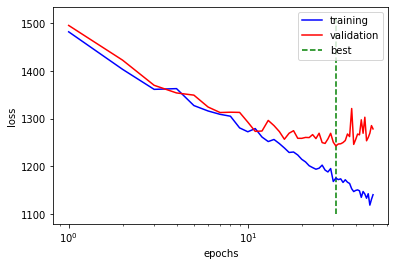

In [ ]:
epochs = 50
wd_rate = 1.0e-6
model = train(train_x, 
              train_labels, 
              train_loader, 
              val_loader, 
              maxepochs=epochs, 
              weight_decay=wd_rate,
              show_epoch_loss_progress=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-2-11-2021-best.pth")

In [ ]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/MAF-MNIST-2-11-2021-best.pth')

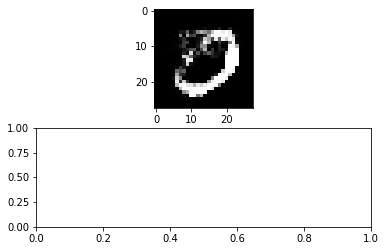

In [ ]:
with torch.no_grad():
  z = model.sample(2)

fig, axs = plt.subplots(2)
z_cpu = z[0].cpu()

axs[0].imshow(inv_logit(z_cpu).detach().numpy().reshape(28,28), cmap='gray')
plt.show()

In [ ]:
def inv_logit(x):
  alpha = 1.0e-6
  return (1.0 / (1.0 + np.exp(-x)) - alpha) / (1 - 2*alpha) 

Test data

In [ ]:
tt_test_x = torch.tensor(test_x, dtype=torch.float32)
tt_test_y = torch.tensor(test_y, dtype=torch.float32)
tt_test_labels = torch.tensor(test_labels, dtype=torch.float32)

if torch.cuda.is_available():
  tt_test_x = tt_test_x.to(device)
  tt_test_y = tt_test_y.to(device)
  tt_test_labels = tt_test_labels.to(device)